In [46]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

In [54]:
%pip install swig
%pip install gymnasium[box2d]

In [68]:
NUM_EPISODES = 1000
BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
TARGET_UPDATE = 20

In [69]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [70]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

In [71]:
class DQNAgent:
    def __init__(self, action_space, observation_space):
        self.action_space = action_space
        self.policy = DQN(observation_space, action_space)
        self.target = DQN(observation_space, action_space)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.memory = ReplayBuffer(10000)
        self.steps_done = 0

    def select_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return torch.tensor([[np.random.randint(self.action_space)]], dtype=torch.long)
        else:
            state = torch.as_tensor(state, dtype=torch.float32)
            if state.dim() == 1:
                state = state.unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy(state)
                return q_values.max(1)[1].view(1, 1)
    
    def optimize_model(self, batch_size, gamma):
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.cat(batch[0])
        action_batch = torch.cat(batch[1])
        reward_batch = torch.cat(batch[2]).squeeze()
        next_state_batch = torch.cat(batch[3])

        current_q_values = self.policy(state_batch).gather(1, action_batch)
        next_q_values = self.target(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + (gamma * next_q_values)
        loss = F.mse_loss(current_q_values.squeeze(), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def update_target(self):
        self.target.load_state_dict(self.policy.state_dict())
            
        

In [ ]:
def train(num_episodes=NUM_EPISODES, batch_size=BATCH_SIZE, gamma=GAMMA, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY, target_update=TARGET_UPDATE):
    env = gym.make('LunarLander-v3')
    agent = DQNAgent(env.action_space.n, env.observation_space.shape[0])

    episode_durations = []
    episode_rewards = []
    epsilon = EPSILON_START

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        total_reward = 0
        for t in range(1000):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, trunc, _ = env.step(action.item())
            total_reward += reward
            reward = torch.tensor([reward], dtype=torch.float32)
            done = done or trunc

            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            agent.memory.push((state, action, reward, next_state))
            state = next_state
            agent.optimize_model(BATCH_SIZE, GAMMA)
            if done:
                episode_durations.append(t + 1)
                episode_rewards.append(total_reward)
                break
            epsilon = max(EPSILON_END, EPSILON_START * (EPSILON_DECAY ** episode))
        if episode % TARGET_UPDATE == 0:
            agent.update_target()
        if episode % 25 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}, AVG Reward: {np.mean(episode_rewards[-25:]):.2f} Epsilon: {epsilon:.2f}")

    env.close()
    return agent, episode_rewards, episode_durations
        

Episode 0, Total Reward: -151.33083512063158, AVG Reward: -151.33 Epsilon: 1.00
Episode 25, Total Reward: -248.88893587726045, AVG Reward: -191.85 Epsilon: 0.88
Episode 50, Total Reward: -311.73467649348413, AVG Reward: -158.07 Epsilon: 0.78
Episode 75, Total Reward: -142.85688147368967, AVG Reward: -134.86 Epsilon: 0.69
Episode 100, Total Reward: -173.66130566711803, AVG Reward: -110.09 Epsilon: 0.61
Episode 125, Total Reward: -36.24889772452691, AVG Reward: -106.98 Epsilon: 0.53
Episode 150, Total Reward: 17.203686537678053, AVG Reward: -38.60 Epsilon: 0.47
Episode 175, Total Reward: -58.677734345375434, AVG Reward: -54.95 Epsilon: 0.42
Episode 200, Total Reward: -38.97499722381989, AVG Reward: -43.35 Epsilon: 0.37
Episode 225, Total Reward: -255.11244373246134, AVG Reward: -143.01 Epsilon: 0.32
Episode 250, Total Reward: 23.26804876712193, AVG Reward: -75.42 Epsilon: 0.29
Episode 275, Total Reward: -23.93697674713536, AVG Reward: -85.12 Epsilon: 0.25
Episode 300, Total Reward: -203.

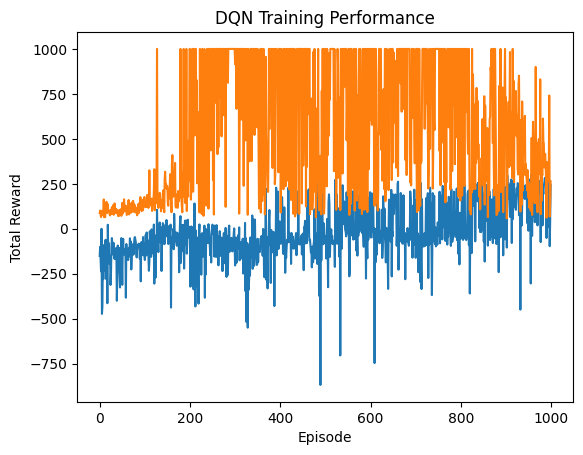

In [ ]:
agent, rewards, durations = train()

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance')
plt.show()

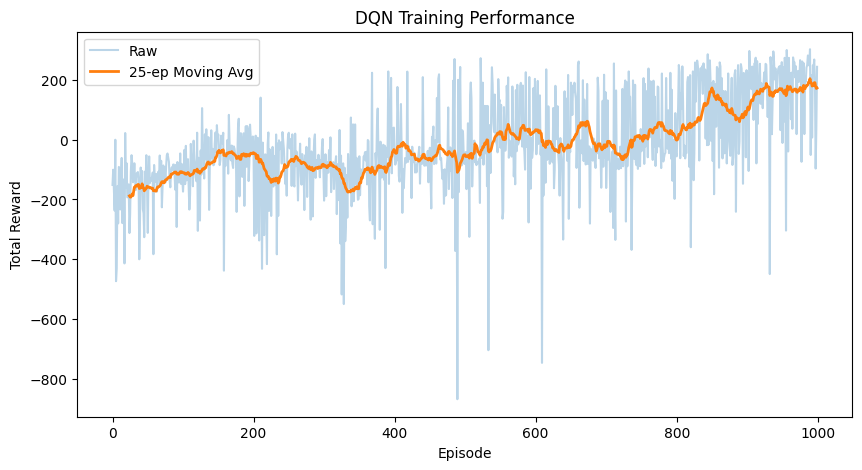

In [ ]:
def plot_rewards(rewards):    
    smooth_rewards = np.convolve(rewards, np.ones(25)/25, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, alpha=0.3, label='Raw')
    plt.plot(range(24, len(rewards)), smooth_rewards, label='25-ep Moving Avg', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Performance')
    plt.legend()
    plt.show()

In [ ]:
agent, rewards, durations = train()
plot_rewards(rewards)

Episode 0, Total Reward: -101.62522324696414, AVG Reward: -101.63 Epsilon: 1.00
Episode 25, Total Reward: -200.77087608047742, AVG Reward: -175.68 Epsilon: 0.88
Episode 50, Total Reward: -163.67564544107114, AVG Reward: -171.87 Epsilon: 0.78
Episode 75, Total Reward: -114.3206093041804, AVG Reward: -146.92 Epsilon: 0.69
Episode 100, Total Reward: -131.5959810360884, AVG Reward: -119.93 Epsilon: 0.61
Episode 125, Total Reward: -94.54074507023199, AVG Reward: -93.79 Epsilon: 0.53
Episode 150, Total Reward: -361.07129422664514, AVG Reward: -108.07 Epsilon: 0.47
Episode 175, Total Reward: -112.57993683886369, AVG Reward: -115.48 Epsilon: 0.42
Episode 200, Total Reward: -383.4584884032459, AVG Reward: -115.62 Epsilon: 0.37
Episode 225, Total Reward: 21.519353369552036, AVG Reward: -134.69 Epsilon: 0.32
Episode 250, Total Reward: 26.02742837735856, AVG Reward: -162.11 Epsilon: 0.29
Episode 275, Total Reward: -26.331965952107694, AVG Reward: -144.93 Epsilon: 0.25
Episode 300, Total Reward: -6

In [ ]:
agent3, rewards3, durations3 = train(500,64,0.99,1.0,0.01,0.995,10)